
# Bolsa de Palavras de Comentários do YouTube 🎒📝

Este notebook:
1. Recebe a **URL de um vídeo do YouTube**  
2. Extrai **todos os comentários** do vídeo (usando a **YouTube Data API v3**)  
3. Limpa o texto e monta uma **bolsa de palavras** (bag-of-words)  
4. Gera **ranking das palavras mais frequentes**, gráficos e uma **nuvem de palavras**  
5. Exporta resultados em CSV e PNG

> ⚠️ **Requisitos**: Você precisa de uma **chave de API** do Google (YouTube Data API v3) — crie em [Google Cloud Console].  
> Se preferir, você pode pular para a célula "Configurações" e colar sua chave lá.


## Instalar dependências

In [ ]:

# Se estiver no Colab, a instalação é necessária. Em ambientes locais, ajuste conforme necessário.
!pip install google-api-python-client pandas nltk matplotlib wordcloud emoji ftfy Unidecode openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.5 MB/s eta 0:00:00


## Imports e configuração do NLTK

In [ ]:

import re
import math
import time
from collections import Counter
from urllib.parse import urlparse, parse_qs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
import emoji
from ftfy import fix_text
from unidecode import unidecode

# Baixar recursos do NLTK (primeira execução)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Evitar warning do matplotlib em alguns ambientes
plt.rcParams.update({"figure.autolayout": True})

from google.colab import userdata


## Configurações

In [ ]:

# === Configurações: preencha aqui ===
VIDEO_URL = "https://www.youtube.com/watch?v=3pksNkfNM2g"  # troque pela URL desejada
API_KEY = userdata.get("GCP_API_KEY")
# Quantidade de palavras no ranking/gráficos
TOP_N = 30

# Opcional: manter acentos na visualização, mas normalizar para contagem
MANTER_ACENTOS_NA_EXIBICAO = True

# Pasta de saída
OUTPUT_DIR = "./"

assert API_KEY and API_KEY != "COLE_SUA_CHAVE_DE_API_AQUI", "Defina sua chave da YouTube Data API v3 em API_KEY."
assert VIDEO_URL, "Defina a URL do vídeo em VIDEO_URL."


## Extrair `videoId` da URL

In [ ]:

def extract_video_id(url: str) -> str:
    """Extrai o ID do vídeo de diferentes formatos de URL do YouTube."""
    parsed = urlparse(url)
    if parsed.hostname in ("youtu.be", "www.youtu.be"):
        return parsed.path.lstrip('/')
    if parsed.hostname and "youtube" in parsed.hostname:
        qs = parse_qs(parsed.query or "")
        if "v" in qs:
            return qs["v"][0]
        # Formatos como /embed/<id> ou /shorts/<id>
        parts = parsed.path.strip('/').split('/')
        if len(parts) >= 2 and parts[0] in ("embed", "shorts", "live"):
            return parts[1]
    raise ValueError("Não foi possível extrair o videoId da URL fornecida.")

video_id = extract_video_id(VIDEO_URL)
video_id


'3pksNkfNM2g'

## Baixar todos os comentários com a YouTube Data API v3

In [ ]:

def get_all_comments(api_key: str, video_id: str, include_replies: bool = True, sleep_s: float = 0.0) -> pd.DataFrame:
    """Busca todos os comentários (top-level e, opcionalmente, respostas) de um vídeo."""
    youtube = build("youtube", "v3", developerKey=api_key, cache_discovery=False)
    comments = []

    def add_comment(item, parent_id=None):
        snippet = item["snippet"]
        top = snippet.get("topLevelComment", {}).get("snippet", {}) if "topLevelComment" in snippet else snippet
        text = top.get("textDisplay") or top.get("textOriginal") or ""
        text = fix_text(text)  # corrige encoding
        comments.append({
            "comment_id": item.get("id"),
            "parent_id": parent_id,
            "author": top.get("authorDisplayName"),
            "published_at": top.get("publishedAt"),
            "like_count": top.get("likeCount"),
            "text": text,
        })

    # Top-level comments
    next_page = None
    while True:
        try:
            req = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                pageToken=next_page,
                textFormat="plainText"
            )
            res = req.execute()
        except HttpError as e:
            raise RuntimeError(f"Erro na API ao buscar comentários: {e}")

        for item in res.get("items", []):
            add_comment(item)
            # replies count
            total_replies = item["snippet"].get("totalReplyCount", 0)
            if include_replies and total_replies:
                # paginate replies
                next_replies = None
                while True:
                    try:
                        rreq = youtube.comments().list(
                            part="snippet",
                            parentId=item["id"],
                            maxResults=100,
                            pageToken=next_replies,
                            textFormat="plainText"
                        )
                        rres = rreq.execute()
                    except HttpError as e:
                        raise RuntimeError(f"Erro na API ao buscar respostas: {e}")
                    for r in rres.get("items", []):
                        add_comment(r, parent_id=item["id"])
                    next_replies = rres.get("nextPageToken")
                    if not next_replies:
                        break
                    if sleep_s:
                        time.sleep(sleep_s)
        next_page = res.get("nextPageToken")
        if not next_page:
            break
        if sleep_s:
            time.sleep(sleep_s)

    df = pd.DataFrame(comments)
    return df

comments_df = get_all_comments(API_KEY, video_id, include_replies=True, sleep_s=0.0)
print(f"Total de linhas (comentários + respostas): {len(comments_df)}")
comments_df.head(3)


Total de linhas (comentários + respostas): 174


,comment_id,parent_id,author,published_at,like_count,text
0,UgyrEtwOXXsiQrca05V4AaABAg,None,@daduribeiro,2025-11-04T08:58:26Z,0,E a burrocracia mantendo o exército pintando m...
1,Ugwm0d9L_TuE8_ip8654AaABAg,None,@MoraisZ139,2025-11-04T06:56:03Z,0,Se essas imagens vai parar nos EUA eles vem aqui
2,UgylQWSkeMI4C_3iCjV4AaABAg,None,@Verde26-q2v,2025-11-04T06:28:17Z,0,O estranho que só mostra esse momento tem trut...


## Salvar comentários brutos (CSV)

In [ ]:
#raw_csv_path = f"{OUTPUT_DIR.rstrip('/')}/youtube_comments_{video_id}.csv"
#comments_df.to_csv(raw_csv_path, index=False)
#print("CSV salvo em:", raw_csv_path)

from google.colab import drive
import os

# Monta o Google Drive (só precisa rodar 1x por sessão)
drive.mount('/content/drive')

# Define a pasta no Drive onde quer salvar (ajuste o caminho abaixo)
# Exemplo: "MyDrive/colab_datasets" → equivale a /content/drive/MyDrive/colab_datasets
OUTPUT_BASE_DIR = "/content/drive/MyDrive/testes_videos_policia"

# Cria um subdiretório com o ID do vídeo
OUTPUT_DIR = os.path.join(OUTPUT_BASE_DIR, f"video_{video_id}")

# Cria a pasta se não existir
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Caminho final do arquivo CSV
raw_csv_path = os.path.join(OUTPUT_DIR, f"youtube_comments_{video_id}.csv")

# Salva o DataFrame
comments_df.to_csv(raw_csv_path, index=False)

print("✅ CSV salvo no Google Drive em:", raw_csv_path)

Mounted at /content/drive
✅ CSV salvo no Google Drive em: /content/drive/MyDrive/testes_videos_policia/video_3pksNkfNM2g/youtube_comments_3pksNkfNM2g.csv


## Limpeza de texto e tokenização

In [ ]:
# --- Stopwords (PT/EN) ---
stop_pt = {w.lower() for w in stopwords.words('portuguese')}
stop_en = {w.lower() for w in stopwords.words('english')}

stop_pt = set(stopwords.words('portuguese'))
stop_en = set(stopwords.words('english'))
stop_custom = {
    # Adicione termos comuns/irrelevantes para YouTube
    "https", "http", "www", "youtube", "youtu", "com", "video", "vídeo", "rt", "amp",
    "pra", "pro", "tá", "tô", "ta", "to", "vc", "vcs", "tb", "q", "pq", "kd", "blz",
}

# Conjuntos auxiliares: com e sem acento (para comparação)
STOP_ALL = {w.lower() for w in (stop_pt | stop_en | stop_custom)}
STOP_ALL_NOACCENT = {unidecode(w) for w in STOP_ALL}

def clean_text(t: str) -> str:
    t = t or ""
    t = fix_text(t)
    # Remove HTML
    t = re.sub(r"<.*?>", " ", t)
    # Remove URLs
    t = re.sub(r"https?://\S+|www\.\S+", " ", t)
    # Remove @menções e #hashtags
    t = re.sub(r"[@#]\w+", " ", t)
    # Converte emojis para espaço (ou texto, se preferir)
    t = emoji.replace_emoji(t, replace=" ")
    # Normaliza espaços
    t = re.sub(r"\s+", " ", t)
    return t.strip()


def tokenize(text: str, manter_acentos_na_exibicao=True):
    cleaned = clean_text(text)
    # >>> NÃO remove acentos aqui (você quer mantê-los) <<<
    count_text = cleaned.lower()

    # Tokenização: \w com UNICODE mantém letras acentuadas
    tokens = re.findall(r"\b\w+\b", count_text, flags=re.UNICODE)

    # Filtra numerais/curtos
    tokens = [t for t in tokens if not t.isdigit() and len(t) > 1]

    # Remove stopwords:
    # - se o token estiver no conjunto com acento (STOP_ALL), OU
    # - se a versão sem acento do token estiver no conjunto sem acento (STOP_ALL_NOACCENT)
    tokens = [t for t in tokens
              if t not in STOP_ALL and unidecode(t) not in STOP_ALL_NOACCENT]

    # view_text preserva acentos para exibição
    view_text = cleaned if manter_acentos_na_exibicao else count_text
    return view_text, tokens


# Aplica às linhas
texts = []
all_tokens = []
for txt in comments_df["text"].astype(str):
    view_text, toks = tokenize(txt, manter_acentos_na_exibicao=MANTER_ACENTOS_NA_EXIBICAO)
    texts.append(view_text)
    all_tokens.extend(toks)

comments_df["clean_text"] = texts
freq = Counter(all_tokens)
freq_df = pd.DataFrame(freq.most_common(), columns=["palavra", "frequencia"])

# Atualiza o caminho para incluir o diretório do vídeo
freq_csv_path = os.path.join(OUTPUT_DIR, f"bow_frequencias_{video_id}.csv")
freq_df.to_csv(freq_csv_path, index=False)

print("Total de tokens (após limpeza):", sum(freq.values()))
print("Vocabulário único:", len(freq_df))
print("CSV de frequências salvo em:", freq_csv_path)

freq_df.head(10)

Total de tokens (após limpeza): 2106
Vocabulário único: 1234
CSV de frequências salvo em: /content/drive/MyDrive/testes_videos_policia/video_3pksNkfNM2g/bow_frequencias_3pksNkfNM2g.csv


,palavra,frequencia
0,policiais,30
1,polícia,26
2,bandidos,18
3,ainda,17
4,vai,13
5,heróis,13
6,ter,13
7,parabéns,12
8,bandido,12
9,deus,12


## Cria a nuvem de palavras e exporta o texto limpo

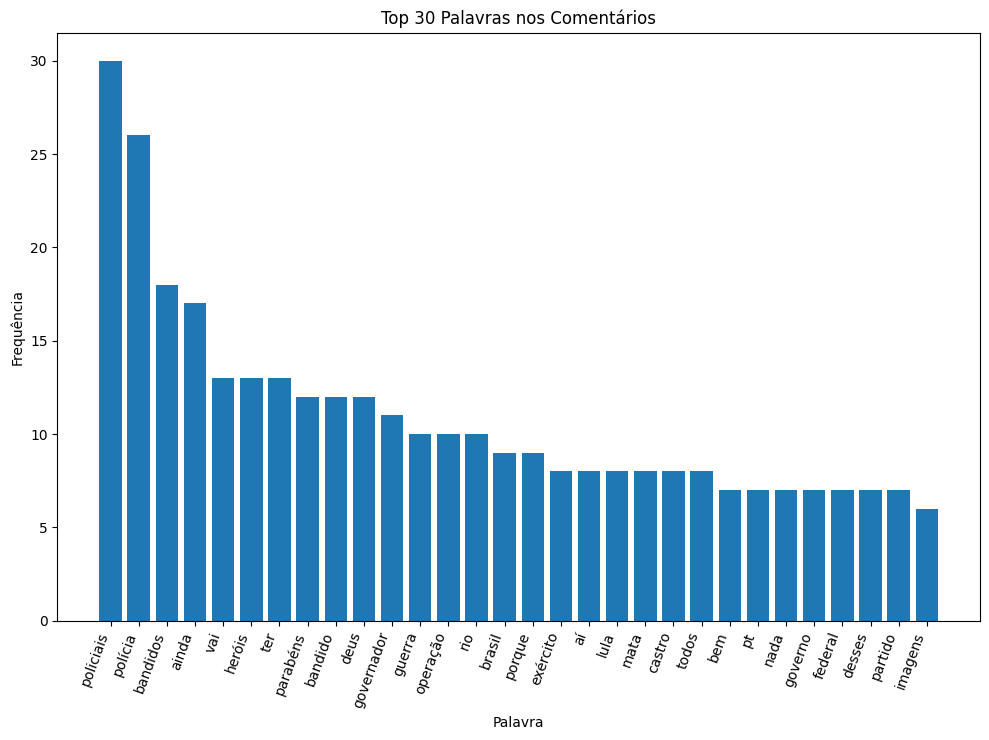

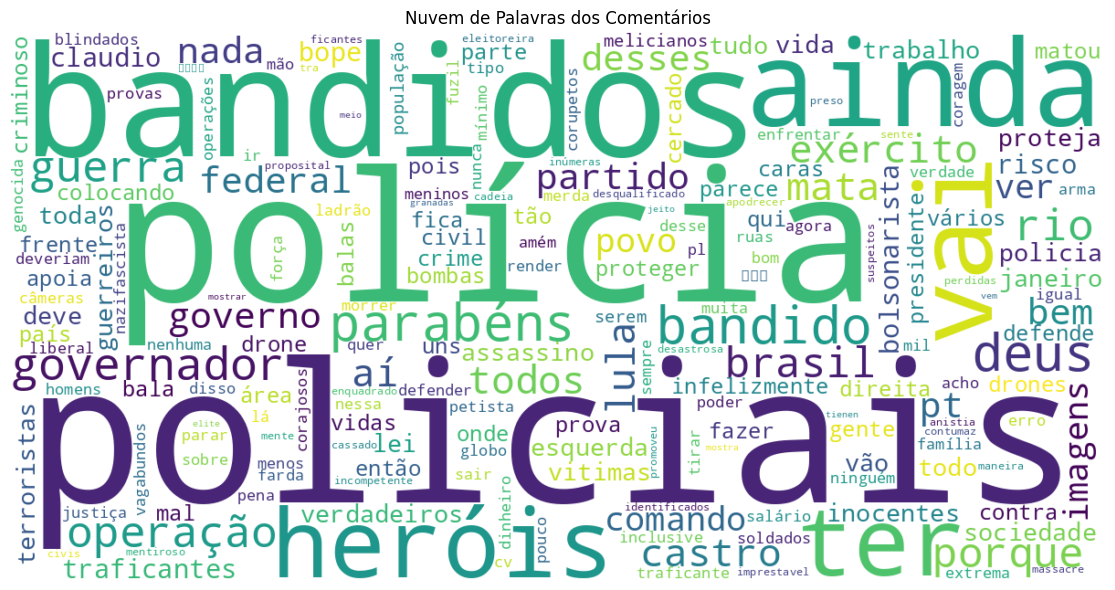

Word cloud salva em: /content/drive/MyDrive/testes_videos_policia/video_3pksNkfNM2g/wordcloud_3pksNkfNM2g.png
CSV com comentários (limpos) salvo em: /content/drive/MyDrive/testes_videos_policia/video_3pksNkfNM2g/youtube_comments_clean_3pksNkfNM2g.csv


In [ ]:
top_df = freq_df.head(TOP_N).copy()
#top_df

## Gráfico: barras das palavras mais frequentes
# Gráfico de barras (sem definir cores explicitamente)
plt.figure(figsize=(10, max(4, TOP_N * 0.25)))
plt.bar(top_df["palavra"], top_df["frequencia"])
plt.xticks(rotation=70, ha="right")
plt.title(f"Top {TOP_N} Palavras nos Comentários")
plt.xlabel("Palavra")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

## Nuvem de palavras (Word Cloud)
# A nuvem usa o dicionário de frequências diretamente
wc = WordCloud(width=1200, height=600, background_color="white")
wc.generate_from_frequencies(dict(freq))

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras dos Comentários")
plt.show()

# Atualiza o caminho para incluir o diretório do vídeo
wc_path = os.path.join(OUTPUT_DIR, f"wordcloud_{video_id}.png")
wc.to_file(wc_path)
print("Word cloud salva em:", wc_path)

## Exportar comentários com texto limpo
# Atualiza o caminho para incluir o diretório do vídeo
clean_csv_path = os.path.join(OUTPUT_DIR, f"youtube_comments_clean_{video_id}.csv")
comments_df.to_csv(clean_csv_path, index=False)
print("CSV com comentários (limpos) salvo em:", clean_csv_path)


## Dicas e solução de problemas

- **Permissões/Quota**: erros `HttpError 403` geralmente indicam falta de permissões no projeto do Google Cloud
  (habilite **YouTube Data API v3**) ou **quota excedida**.
- **Idioma/Stopwords**: ajuste a lista `stop_custom` para termos específicos do seu nicho.
- **Acentos**: se desejar contar acentos distintamente, defina `MANTER_ACENTOS_NA_EXIBICAO = True` e troque a linha de normalização em `tokenize`.
- **Velocidade**: para vídeos com muitos comentários, a coleta pode levar alguns minutos devido à paginação da API.
- **Sem API key?** Você pode usar bibliotecas de scraping de terceiros, mas elas quebram com frequência e podem violar termos de uso. O método oficial (API) é recomendado.


## Faz a análise das emoções

In [ ]:
import os, json, time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import seaborn as sns

Classificando comentários 0 a 100...
Classificando comentários 100 a 174...

Arquivo salvo em: /content/drive/MyDrive/testes_videos_policia/video_3pksNkfNM2g/sentimentos_comentarios_operacoes.csv


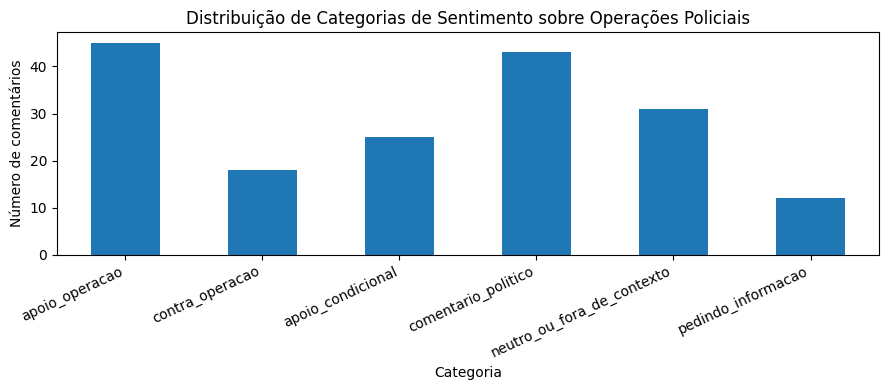

In [ ]:
# Configuração
MODEL = "gpt-4.1-mini"
BATCH_SIZE = 100
MAX_COMENTS = 1000

api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise RuntimeError("Defina OPENAI_API_KEY")

client = OpenAI(api_key=api_key)

# Categorias definidas no prompt
CATEGORIES = [
    "apoio_operacao",
    "contra_operacao",
    "apoio_condicional",
    "comentario_politico",
    "neutro_ou_fora_de_contexto",
    "pedindo_informacao"
]

# GO_EMOTIONS está definido no código que gerou este cell.
# Para evitar erro de NameError, definimos aqui caso o usuário execute este cell isoladamente.

instructions = """Você é um analista de opinião pública. Sua tarefa é avaliar a reação da população em relação à atuação da polícia em operações registradas em vídeos de câmeras corporais.

Você receberá comentários desses vídeos.
Classifique **cada comentário** em **uma e apenas uma** das seguintes categorias:

1. apoio_operacao → demonstra apoio, aprovação ou concordância com a atuação da polícia
2. contra_operacao → demonstra desaprovação, crítica ou reprovação à atuação da polícia
3. apoio_condicional → demonstra apoio com ressalvas ou críticas parciais
4. comentario_politico → trata de política, ideologia ou governo, mas não avalia a atuação policial diretamente
5. neutro_ou_fora_de_contexto → comentário neutro, irrelevante ou sobre outro aspecto do vídeo (música, edição, etc.)
6. pedindo_informacao → comentário que apenas faz perguntas sobre o vídeo

Retorne **somente em JSON**, no formato:

{
  "items": [
    {"index": 0, "categoria": "<uma_das_categorias>", "confidence": <0-1>},
    {"index": 1, "categoria": "<uma_das_categorias>", "confidence": <0-1>}
  ]
}

Não inclua texto adicional fora do JSON.

Instruções adicionais:
- Foque exclusivamente na atuação da polícia, e não em aspectos políticos, técnicos ou visuais do vídeo.
- Se o comentário mencionar governo, ideologia ou leis, mas não avaliar a ação dos policiais, classifique como “comentario_politico”.
- Se houver dúvida sobre o sentido, escolha “neutro_ou_fora_de_contexto”.

"""

# =====================================
# FUNÇÃO DE CLASSIFICAÇÃO
# =====================================
def classify_batch(texts, offset=0, retry=2):
    """Usa Chat Completions para análise de lote"""
    for attempt in range(retry + 1):
        try:
            prompt = "Classifique as seguintes frases:\n\n"
            for i, t in enumerate(texts):
                prompt += f"index={i+offset}\ntexto: {t}\n\n"

            response = client.chat.completions.create(
                model=MODEL,
                temperature=0,
                response_format={"type": "json_object"},
                messages=[
                    {"role": "system", "content": instructions},
                    {"role": "user", "content": prompt}
                ]
            )

            raw = response.choices[0].message.content
            data = json.loads(raw)
            return data.get("items", [])
        except Exception as e:
            if attempt == retry:
                raise
            time.sleep(0.8 * (attempt + 1))

# =====================================
# EXECUÇÃO EM LOTE
# =====================================
# Ordena comentários por likes (ou outra métrica, se quiser)
comments_df = comments_df.sort_values(by='like_count', ascending=False)

texts = comments_df["text"].astype(str).tolist()
results = []

for start in range(0, min(len(texts), MAX_COMENTS), BATCH_SIZE):
    batch = texts[start:start + BATCH_SIZE]
    print(f"Classificando comentários {start} a {start + len(batch)}...")
    items = classify_batch(batch, offset=start)
    results.extend(items)

# =====================================
# MONTAGEM DO DATAFRAME FINAL
# =====================================
by_idx = {it["index"]: it for it in results}
categorias = []
confidences = []

for i, _ in enumerate(texts):
    rec = by_idx.get(i)
    if rec:
        categoria = rec.get("categoria") or rec.get("emotion") or "neutro_ou_fora_de_contexto"
        if categoria not in CATEGORIES:
            categoria = "neutro_ou_fora_de_contexto"
        categorias.append(categoria)
        confidences.append(rec.get("confidence"))
    else:
        categorias.append("neutro_ou_fora_de_contexto")
        confidences.append(None)

df_sent = pd.DataFrame({
    "texto": texts,
    "categoria": categorias,
    "confianca": confidences
})

# =====================================
# SALVAR CSV
# =====================================
sent_csv_path = os.path.join(OUTPUT_DIR, "sentimentos_comentarios_operacoes.csv")
df_sent.to_csv(sent_csv_path, index=False)
print(f"\nArquivo salvo em: {sent_csv_path}")

# =====================================
# VISUALIZAÇÃO RÁPIDA
# =====================================
counts = df_sent["categoria"].value_counts().reindex(CATEGORIES, fill_value=0)

plt.figure(figsize=(9, 4))
counts.plot(kind="bar")
plt.title("Distribuição de Categorias de Sentimento sobre Operações Policiais")
plt.ylabel("Número de comentários")
plt.xlabel("Categoria")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

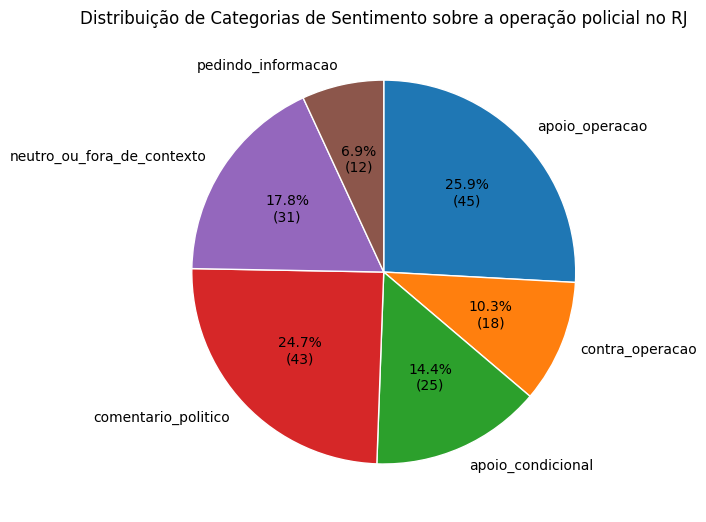

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(counts) / 100)})',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Distribuição de Categorias de Sentimento sobre a operação policial no RJ")
plt.tight_layout()
plt.show()